# Processing data for modelling

In [1]:
import pandas as pd
from tqdm import tqdm

from functions import print_shape, df_security_code

from feature_engineering import (fill_and_drop_na_values,
 adjust_price, 
 price_new_features, 
 encode_flag,
 fill_finances_knn,
 new_features_financial
 )

MISSINGVALUES = True

## import data

In [2]:
def data_selection(selection = False):
    if selection:
        prices = df_security_code(pd.read_csv('data/train_files/stock_prices.csv', parse_dates=[1]))
        financial = df_security_code(pd.read_csv('data/train_files/financials.csv',parse_dates=['Date']))
    else: 
        prices = pd.read_csv('data/train_files/stock_prices.csv', parse_dates=[1])
        financial = pd.read_csv('data/train_files/financials.csv',parse_dates=['Date'])
    return prices, financial

In [3]:
# helper function
def save_and_load(df):
    df_name = name =[x for x in globals() if globals()[x] is df][0]
    name = 'data/curr_' + df_name + '.csv'
    df.to_csv(name)
    del df
    return pd.read_csv(name, parse_dates=['Date'], index_col=[0] )

In [4]:
prices, financial = data_selection()

In [5]:
prices.head(2)

,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,NaN,False,0.000730
1,20170104_1332,2017-01-04,1332,568.0,576.0,563.0,571.0,2798500,1.0,NaN,False,0.012324


In [6]:
financial.head(2)

,DisclosureNumber,DateCode,Date,SecuritiesCode,DisclosedDate,DisclosedTime,DisclosedUnixTime,TypeOfDocument,CurrentPeriodEndDate,TypeOfCurrentPeriod,...,ForecastEarningsPerShare,ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,MaterialChangesInSubsidiaries,ChangesBasedOnRevisionsOfAccountingStandard,ChangesOtherThanOnesBasedOnRevisionsOfAccountingStandard,ChangesInAccountingEstimates,RetrospectiveRestatement,NumberOfIssuedAndOutstandingSharesAtTheEndOfFiscalYearIncludingTreasuryStock,NumberOfTreasuryStockAtTheEndOfFiscalYear,AverageNumberOfShares
0,2.016121e+13,20170104_2753,2017-01-04,2753.0,2017-01-04,07:30:00,1.483483e+09,3QFinancialStatements_Consolidated_JP,2016-12-31,3Q,...,319.76,NaN,False,True,False,False,False,6848800.0,－,6848800.0
1,2.017010e+13,20170104_3353,2017-01-04,3353.0,2017-01-04,15:00:00,1.483510e+09,3QFinancialStatements_Consolidated_JP,2016-11-30,3Q,...,485.36,NaN,False,True,False,False,False,2035000.0,118917,1916083.0


## - Stock price

In [7]:
# test with feature_engineering.py
#prices = pd.read_csv('data/train_files/stock_prices.csv', parse_dates=[1])
print_shape(prices, MISSINGVALUES)
#prices.head(2)

 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       12
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')
----------------------------------------


,N_missing,Percentage
ExpectedDividend,2313666.0,99.19
Open,7608.0,0.33
High,7608.0,0.33
Low,7608.0,0.33
Close,7608.0,0.33
Target,238.0,0.01
RowId,0.0,0.00
Date,0.0,0.00
SecuritiesCode,0.0,0.00
Volume,0.0,0.00


In [8]:

#from feature_engineering import fill_and_drop_na_values

# fill na
fill_prices = fill_and_drop_na_values(prices, drop=False)

# save and load

fill_prices = save_and_load(fill_prices)

fill_prices.to_csv('data/curr_fill_prices.csv')
print_shape(fill_prices, MISSINGVALUES)
fill_prices.head(2)



100%|██████████| 2000/2000 [03:50<00:00,  8.69it/s]


 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       12
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'Open', 'High', 'Low', 'Close',
       'Volume', 'AdjustmentFactor', 'ExpectedDividend', 'SupervisionFlag',
       'Target'],
      dtype='object')
----------------------------------------


,N_missing,Percentage
Open,264.0,0.01
High,264.0,0.01
Low,264.0,0.01
Close,264.0,0.01
Target,238.0,0.01
RowId,0.0,0.00
Date,0.0,0.00
SecuritiesCode,0.0,0.00
Volume,0.0,0.00
AdjustmentFactor,0.0,0.00


,RowId,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,Target
0,20170104_1301,2017-01-04,1301,2734.0,2755.0,2730.0,2742.0,31400,1.0,0.0,False,0.00073
1865,20170105_1301,2017-01-05,1301,2743.0,2747.0,2735.0,2738.0,17900,1.0,0.0,False,0.00292


In [9]:
#fill_prices = pd.read_csv('data/curr_fill_prices.csv', parse_dates=['Date'], index_col=[0])
#print_shape(fill_prices)

In [10]:



ad_price = adjust_price(fill_prices)
ad_price = save_and_load(ad_price)
print_shape(ad_price, MISSINGVALUES)
ad_price.head(2)
#del ad_price

100%|██████████| 2000/2000 [04:11<00:00,  7.96it/s]


 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       12
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low',
       'ad_Close', 'ad_Volume', 'ad_Target'],
      dtype='object')
----------------------------------------


,N_missing,Percentage
ad_Target,4238.0,0.18
ad_Open,264.0,0.01
ad_High,264.0,0.01
ad_Low,264.0,0.01
ad_Close,264.0,0.01
RowId,0.0,0.00
Date,0.0,0.00
SecuritiesCode,0.0,0.00
AdjustmentFactor,0.0,0.00
ExpectedDividend,0.0,0.00


,RowId,Date,SecuritiesCode,AdjustmentFactor,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,ad_Target
1483,20170104_8194,2017-01-04,8194,1.0,0.0,False,3325.0,3390.0,3300.0,3380.0,36100.0,-0.002963
3348,20170105_8194,2017-01-05,8194,1.0,0.0,False,3395.0,3420.0,3360.0,3375.0,19400.0,-0.020802


In [11]:
#ad_price = pd.read_csv('data/curr_ad_price.csv', parse_dates=['Date'], index_col=[0])
#print_shape(ad_price)

In [12]:
#from feature_engineering import price_new_features, encode_flag

ad_price_feat = price_new_features(ad_price)

ad_price_feat['SupervisionFlag'] = encode_flag(ad_price_feat)
#ad_price_feat.to_csv('data/curr_ad_price_feat.csv')

ad_price_feat = save_and_load(ad_price_feat)

print_shape(ad_price_feat, MISSINGVALUES)


100%|██████████| 2000/2000 [1:02:16<00:00,  1.87s/it]


 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       53
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'AdjustmentFactor',
       'ExpectedDividend', 'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low',
       'ad_Close', 'ad_Volume', 'ad_Target', 'ad_Close_lag1', 'ad_Close_sma10',
       'logprice_ad_Close', 'trend_ad_Close', 'detrend_ad_Close',
       'season_ad_Close', 'error_ad_Close', 'ad_Open_lag1', 'ad_Open_sma10',
       'logprice_ad_Open', 'trend_ad_Open', 'detrend_ad_Open',
       'season_ad_Open', 'error_ad_Open', 'ad_High_lag1', 'ad_High_sma10',
       'logprice_ad_High', 'trend_ad_High', 'detrend_ad_High',
       'season_ad_High', 'error_ad_High', 'ad_Low_lag1', 'ad_Low_sma10',
       'logprice_ad_Low', 'trend_ad_Low', 'detrend_ad_Low', 'season_ad_Low',
       'error_ad_Low', 'ad_Volume_lag1', 'ad_Volume_sma10', 'RSI', 'Return',
       'Log_Return', 'macd', 'macd_h', 'ma

,N_missing,Percentage
trend_ad_Close,58264.0,2.50
detrend_ad_High,58264.0,2.50
season_ad_High,58264.0,2.50
error_ad_High,58264.0,2.50
error_ad_Open,58264.0,2.50
season_ad_Open,58264.0,2.50
detrend_ad_Open,58264.0,2.50
trend_ad_Open,58264.0,2.50
error_ad_Close,58264.0,2.50
season_ad_Close,58264.0,2.50


In [13]:
dateL = ['Date', 'Year',
       'week', 'Day', 'Month' ]

In [14]:
ad_price_feat[dateL]

,Date,Year,week,Day,Month
1483,2017-01-04,2017.0,1.0,4.0,1.0
3348,2017-01-05,2017.0,1.0,5.0,1.0
5213,2017-01-06,2017.0,1.0,6.0,1.0
7078,2017-01-10,2017.0,2.0,10.0,1.0
8943,2017-01-11,2017.0,2.0,11.0,1.0
...,...,...,...,...,...
2324136,2021-11-29,2021.0,48.0,29.0,11.0
2326136,2021-11-30,2021.0,48.0,30.0,11.0
2328136,2021-12-01,2021.0,48.0,1.0,12.0
2330136,2021-12-02,2021.0,48.0,2.0,12.0


In [15]:
#ad_price_feat =  pd.read_csv('data/curr_ad_price_feat.csv', parse_dates=['Date'], index_col=[0])
#print_shape(ad_price_feat)

## - Financials

In [16]:
#from feature_engineering import fill_finances

#financial = financial = pd.read_csv('data/train_files/financials.csv',parse_dates=['Date'])
#financial.head(2)

In [17]:
print_shape(financial)

 Shape:
 ----------------------------------------
 Observations:   93K
 Features:       45
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['DisclosureNumber', 'DateCode', 'Date', 'SecuritiesCode',
       'DisclosedDate', 'DisclosedTime', 'DisclosedUnixTime', 'TypeOfDocument',
       'CurrentPeriodEndDate', 'TypeOfCurrentPeriod',
       'CurrentFiscalYearStartDate', 'CurrentFiscalYearEndDate', 'NetSales',
       'OperatingProfit', 'OrdinaryProfit', 'Profit', 'EarningsPerShare',
       'TotalAssets', 'Equity', 'EquityToAssetRatio', 'BookValuePerShare',
       'ResultDividendPerShare1stQuarter', 'ResultDividendPerShare2ndQuarter',
       'ResultDividendPerShare3rdQuarter',
       'ResultDividendPerShareFiscalYearEnd', 'ResultDividendPerShareAnnual',
       'ForecastDividendPerShare1stQuarter',
       'ForecastDividendPerShare2ndQuarter',
       'ForecastDividendPerShare3rdQuarter',
       'ForecastDividendPerShareFiscalYearEnd',
       'ForecastDividendPer

,N_missing,Percentage
ApplyingOfSpecificAccountingOfTheQuarterlyFinancialStatements,85707.0,92.20
ForecastDividendPerShare1stQuarter,73715.0,79.30
ResultDividendPerShareAnnual,73541.0,79.11
ResultDividendPerShareFiscalYearEnd,73540.0,79.11
BookValuePerShare,57183.0,61.52
ResultDividendPerShare3rdQuarter,55279.0,59.47
ForecastDividendPerShare2ndQuarter,50337.0,54.15
ResultDividendPerShare2ndQuarter,37016.0,39.82
ForecastDividendPerShare3rdQuarter,32149.0,34.59
MaterialChangesInSubsidiaries,28452.0,30.61


In [18]:
filled_financial = fill_finances_knn(financial, prices)

100%|██████████| 2000/2000 [00:04<00:00, 402.74it/s]


In [19]:
filled_financial.head()

,Date,Day,Month,Year,SecuritiesCode,Profit,NetSales
0,2017-02-10,10.0,2.0,2017.0,1301.0,2.449000e+09,1.799750e+11
1,2017-05-11,11.0,5.0,2017.0,1301.0,2.422000e+09,2.365610e+11
2,2017-08-04,4.0,8.0,2017.0,1301.0,7.540000e+08,5.684400e+10
3,2017-11-06,6.0,11.0,2017.0,1301.0,1.633000e+09,1.204580e+11
4,2018-02-09,9.0,2.0,2018.0,1301.0,2.784000e+09,1.983230e+11


In [20]:
from feature_engineering import fill_finances_knn



filled_financial = fill_finances_knn(financial, prices)
#filled_financial.to_csv('data/curr_filled_finances.csv')

filled_financial = save_and_load(filled_financial)

print_shape(filled_financial, MISSINGVALUES)
filled_financial.head(2)
#del filled_finances

100%|██████████| 2000/2000 [00:04<00:00, 414.29it/s]


 Shape:
 ----------------------------------------
 Observations:   38.8K
 Features:       7
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['Date', 'Day', 'Month', 'Year', 'SecuritiesCode', 'Profit', 'NetSales'], dtype='object')
----------------------------------------


,N_missing,Percentage
Date,0.0,0.0
Day,0.0,0.0
Month,0.0,0.0
Year,0.0,0.0
SecuritiesCode,0.0,0.0
Profit,0.0,0.0
NetSales,0.0,0.0


,Date,Day,Month,Year,SecuritiesCode,Profit,NetSales
0,2017-02-10,10.0,2.0,2017.0,1301.0,2.449000e+09,1.799750e+11
1,2017-05-11,11.0,5.0,2017.0,1301.0,2.422000e+09,2.365610e+11


In [21]:
#filled_finances = pd.read_csv('data/curr_filled_finances.csv', parse_dates=['Date'], index_col=[0])
#print_shape(filled_finances)

In [22]:
from feature_engineering import new_features_financial

filled_financial_features = new_features_financial(filled_financial)

#filled_financial_features.to_csv('data/curr_filled_financial_features.csv')
filled_financial_features = save_and_load(filled_financial_features)
print_shape(filled_financial_features)
filled_financial_features.head()



100%|██████████| 2000/2000 [00:40<00:00, 49.13it/s]


 Shape:
 ----------------------------------------
 Observations:   38.8K
 Features:       12
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['Date', 'Day', 'Month', 'Year', 'SecuritiesCode', 'Profit', 'NetSales',
       'margin', 'win_quarter_growth', 'rev_quarter_growth', 'margin_growth',
       'RowId'],
      dtype='object')
----------------------------------------


,N_missing,Percentage
win_quarter_growth,2000.0,5.16
rev_quarter_growth,2000.0,5.16
margin_growth,2000.0,5.16
Date,0.0,0.00
Day,0.0,0.00
Month,0.0,0.00
Year,0.0,0.00
SecuritiesCode,0.0,0.00
Profit,0.0,0.00
NetSales,0.0,0.00


,Date,Day,Month,Year,SecuritiesCode,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth,RowId
0,2017-02-10,10.0,2.0,2017.0,1301,2.449000e+09,1.799750e+11,1.360745,NaN,NaN,NaN,20170210_1301
1,2017-05-11,11.0,5.0,2017.0,1301,2.422000e+09,2.365610e+11,1.023837,-1.102491,31.441033,-24.759030,20170511_1301
2,2017-08-04,4.0,8.0,2017.0,1301,7.540000e+08,5.684400e+10,1.326437,-68.868704,-75.970680,29.555461,20170804_1301
3,2017-11-06,6.0,11.0,2017.0,1301,1.633000e+09,1.204580e+11,1.355659,116.578249,111.909788,2.203042,20171106_1301
4,2018-02-09,9.0,2.0,2018.0,1301,2.784000e+09,1.983230e+11,1.403771,70.483772,64.640788,3.548929,20180209_1301


In [23]:
filled_financial_features[['Date', 'Year', 'Day', 'Month' ]]

,Date,Year,Day,Month
0,2017-02-10,2017.0,10.0,2.0
1,2017-05-11,2017.0,11.0,5.0
2,2017-08-04,2017.0,4.0,8.0
3,2017-11-06,2017.0,6.0,11.0
4,2018-02-09,2018.0,9.0,2.0
...,...,...,...,...
3,2021-11-12,2021.0,12.0,11.0
0,2021-02-12,2021.0,12.0,2.0
1,2021-05-14,2021.0,14.0,5.0
2,2021-08-13,2021.0,13.0,8.0


In [24]:
#filled_financial_features.SecuritiesCode = filled_financial_features.SecuritiesCode.astype(int)

In [25]:
filled_financial_features.head(2)

,Date,Day,Month,Year,SecuritiesCode,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth,RowId
0,2017-02-10,10.0,2.0,2017.0,1301,2.449000e+09,1.799750e+11,1.360745,NaN,NaN,NaN,20170210_1301
1,2017-05-11,11.0,5.0,2017.0,1301,2.422000e+09,2.365610e+11,1.023837,-1.102491,31.441033,-24.75903,20170511_1301


In [26]:
ad_price_feat.head(2)

,RowId,Date,SecuritiesCode,AdjustmentFactor,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,...,Return,Log_Return,macd,macd_h,macd_s,Day,Month,Year,week,Volatility_week
1483,20170104_8194,2017-01-04,8194,1.0,0.0,0,3325.0,3390.0,3300.0,3380.0,...,NaN,NaN,NaN,NaN,NaN,4.0,1.0,2017.0,1.0,0.235112
3348,20170105_8194,2017-01-05,8194,1.0,0.0,0,3395.0,3420.0,3360.0,3375.0,...,0.998521,-0.00148,NaN,NaN,NaN,5.0,1.0,2017.0,1.0,0.235112


## - financials + price

In [27]:
# create key on financial : RowId
#filled_financial_features['RowId'] = filled_financial_features.Date.dt.strftime('%Y%m%d').astype(str) + '_' + filled_financial_features.SecuritiesCode.astype(str)

In [28]:
#filled_financial_features.sort_values('Date').head(20)

In [29]:
#filled_financial_features.RowId.info()

In [30]:
from feature_engineering import price_financial_function

In [31]:
# concat financials and price
#price_financial = price_financial_function(ad_price_feat, filled_financial_features)
price_financial = pd.merge(ad_price_feat, filled_financial_features, how='left', on='RowId', suffixes=[None, '_f_'])
#price_financial = pd.concat([ad_price, filled_financial_features], keys='RowID')

fea_to_remove = ['Date_f_', 'Day_f_', 'Month_f_', 'Year_f_', 'SecuritiesCode_f_','Log_Return', 'AdjustmentFactor']
price_financial.drop(fea_to_remove, axis=1, inplace=True)

price_financial = save_and_load(price_financial)
print_shape(price_financial)
price_financial.head()

 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       57
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'ExpectedDividend',
       'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close',
       'ad_Volume', 'ad_Target', 'ad_Close_lag1', 'ad_Close_sma10',
       'logprice_ad_Close', 'trend_ad_Close', 'detrend_ad_Close',
       'season_ad_Close', 'error_ad_Close', 'ad_Open_lag1', 'ad_Open_sma10',
       'logprice_ad_Open', 'trend_ad_Open', 'detrend_ad_Open',
       'season_ad_Open', 'error_ad_Open', 'ad_High_lag1', 'ad_High_sma10',
       'logprice_ad_High', 'trend_ad_High', 'detrend_ad_High',
       'season_ad_High', 'error_ad_High', 'ad_Low_lag1', 'ad_Low_sma10',
       'logprice_ad_Low', 'trend_ad_Low', 'detrend_ad_Low', 'season_ad_Low',
       'error_ad_Low', 'ad_Volume_lag1', 'ad_Volume_sma10', 'RSI', 'Return',
       'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year', 'we

,N_missing,Percentage
margin_growth,2295802.0,98.43
rev_quarter_growth,2295802.0,98.43
win_quarter_growth,2295802.0,98.43
margin,2293808.0,98.34
NetSales,2293808.0,98.34
Profit,2293808.0,98.34
error_ad_High,58264.0,2.50
season_ad_Open,58264.0,2.50
error_ad_Open,58264.0,2.50
detrend_ad_High,58264.0,2.50


,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
0,20170104_8194,2017-01-04,8194,0.0,0,3325.0,3390.0,3300.0,3380.0,36100.0,...,1.0,2017.0,1.0,0.235112,NaN,NaN,NaN,NaN,NaN,NaN
1,20170105_8194,2017-01-05,8194,0.0,0,3395.0,3420.0,3360.0,3375.0,19400.0,...,1.0,2017.0,1.0,0.235112,NaN,NaN,NaN,NaN,NaN,NaN
2,20170106_8194,2017-01-06,8194,0.0,0,3365.0,3385.0,3335.0,3365.0,23000.0,...,1.0,2017.0,1.0,0.235112,NaN,NaN,NaN,NaN,NaN,NaN
3,20170110_8194,2017-01-10,8194,0.0,0,3350.0,3360.0,3290.0,3295.0,42400.0,...,1.0,2017.0,2.0,8.008821,NaN,NaN,NaN,NaN,NaN,NaN
4,20170111_8194,2017-01-11,8194,0.0,0,3330.0,3330.0,3260.0,3275.0,20200.0,...,1.0,2017.0,2.0,8.008821,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
price_financial[dateL]

,Date,Year,week,Day,Month
0,2017-01-04,2017.0,1.0,4.0,1.0
1,2017-01-05,2017.0,1.0,5.0,1.0
2,2017-01-06,2017.0,1.0,6.0,1.0
3,2017-01-10,2017.0,2.0,10.0,1.0
4,2017-01-11,2017.0,2.0,11.0,1.0
...,...,...,...,...,...
2332534,2021-11-29,2021.0,48.0,29.0,11.0
2332535,2021-11-30,2021.0,48.0,30.0,11.0
2332536,2021-12-01,2021.0,48.0,1.0,12.0
2332537,2021-12-02,2021.0,48.0,2.0,12.0


In [33]:
#price_financial_fill = ffill_pro_code(price_financial)
price_financial_fill = fill_and_drop_na_values(price_financial, drop=False)

price_financial_fill = save_and_load(price_financial_fill)

print_shape(price_financial_fill)
price_financial_fill.head(2)


100%|██████████| 2000/2000 [36:28<00:00,  1.09s/it]


 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       57
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'ExpectedDividend',
       'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close',
       'ad_Volume', 'ad_Target', 'ad_Close_lag1', 'ad_Close_sma10',
       'logprice_ad_Close', 'trend_ad_Close', 'detrend_ad_Close',
       'season_ad_Close', 'error_ad_Close', 'ad_Open_lag1', 'ad_Open_sma10',
       'logprice_ad_Open', 'trend_ad_Open', 'detrend_ad_Open',
       'season_ad_Open', 'error_ad_Open', 'ad_High_lag1', 'ad_High_sma10',
       'logprice_ad_High', 'trend_ad_High', 'detrend_ad_High',
       'season_ad_High', 'error_ad_High', 'ad_Low_lag1', 'ad_Low_sma10',
       'logprice_ad_Low', 'trend_ad_Low', 'detrend_ad_Low', 'season_ad_Low',
       'error_ad_Low', 'ad_Volume_lag1', 'ad_Volume_sma10', 'RSI', 'Return',
       'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year', 'we

,N_missing,Percentage
margin_growth,171105.0,7.34
rev_quarter_growth,171105.0,7.34
win_quarter_growth,171105.0,7.34
season_ad_Close,58264.0,2.50
error_ad_Low,58264.0,2.50
season_ad_Low,58264.0,2.50
detrend_ad_Low,58264.0,2.50
trend_ad_Low,58264.0,2.50
error_ad_High,58264.0,2.50
season_ad_High,58264.0,2.50


,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
0,20170104_8194,2017-01-04,8194,0.0,0,3325.0,3390.0,3300.0,3380.0,36100.0,...,1.0,2017.0,1.0,0.235112,NaN,NaN,NaN,NaN,NaN,NaN
1,20170105_8194,2017-01-05,8194,0.0,0,3395.0,3420.0,3360.0,3375.0,19400.0,...,1.0,2017.0,1.0,0.235112,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
price_financial_fill[dateL]

,Date,Year,week,Day,Month
0,2017-01-04,2017.0,1.0,4.0,1.0
1,2017-01-05,2017.0,1.0,5.0,1.0
2,2017-01-06,2017.0,1.0,6.0,1.0
3,2017-01-10,2017.0,2.0,10.0,1.0
4,2017-01-11,2017.0,2.0,11.0,1.0
...,...,...,...,...,...
2332534,2021-11-29,2021.0,48.0,29.0,11.0
2332535,2021-11-30,2021.0,48.0,30.0,11.0
2332536,2021-12-01,2021.0,48.0,1.0,12.0
2332537,2021-12-02,2021.0,48.0,2.0,12.0


In [35]:
# save dataframe to csv
price_financial_fill.to_csv('data/curr_filled_financial_features.csv')

In [36]:
print_shape(price_financial_fill, False)

 Shape:
 ----------------------------------------
 Observations:   2.33M
 Features:       57
 Feature Date:    datetime64[ns]
----------------------------------------
Index(['RowId', 'Date', 'SecuritiesCode', 'ExpectedDividend',
       'SupervisionFlag', 'ad_Open', 'ad_High', 'ad_Low', 'ad_Close',
       'ad_Volume', 'ad_Target', 'ad_Close_lag1', 'ad_Close_sma10',
       'logprice_ad_Close', 'trend_ad_Close', 'detrend_ad_Close',
       'season_ad_Close', 'error_ad_Close', 'ad_Open_lag1', 'ad_Open_sma10',
       'logprice_ad_Open', 'trend_ad_Open', 'detrend_ad_Open',
       'season_ad_Open', 'error_ad_Open', 'ad_High_lag1', 'ad_High_sma10',
       'logprice_ad_High', 'trend_ad_High', 'detrend_ad_High',
       'season_ad_High', 'error_ad_High', 'ad_Low_lag1', 'ad_Low_sma10',
       'logprice_ad_Low', 'trend_ad_Low', 'detrend_ad_Low', 'season_ad_Low',
       'error_ad_Low', 'ad_Volume_lag1', 'ad_Volume_sma10', 'RSI', 'Return',
       'macd', 'macd_h', 'macd_s', 'Day', 'Month', 'Year', 'we

final


In [37]:
df = pd.read_csv('data/curr_price_financial_fill.csv', parse_dates=['Date'], index_col=[0])

In [38]:
from functions import missingValues
missingValues(df)

,N_missing,Percentage
margin_growth,171105.0,7.34
rev_quarter_growth,171105.0,7.34
win_quarter_growth,171105.0,7.34
season_ad_Close,58264.0,2.50
error_ad_Low,58264.0,2.50
season_ad_Low,58264.0,2.50
detrend_ad_Low,58264.0,2.50
trend_ad_Low,58264.0,2.50
error_ad_High,58264.0,2.50
season_ad_High,58264.0,2.50


In [39]:
import numpy as np


In [40]:
#df.dropna(inplace=True)

In [41]:
df.shape

(2332539, 57)

In [42]:
import seaborn as sns

In [43]:

from functions import plot_stock
import matplotlib.pyplot as plt


In [44]:
def train_test_split(df, split= 22):
    #df.dropna(inplace=True)
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()

    for i in tqdm(df.SecuritiesCode.unique()):
        df_selected = df.query('SecuritiesCode == @i').sort_values('Date')
        df_test, df_train = df_selected[-split:], df_selected[:-split]

        train_data = pd.concat([train_data, df_train])
        test_data = pd.concat([test_data, df_test])

    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])

    return train_data, test_data

In [45]:
train_data, test_data = train_test_split(df)

#train_data = save_and_load(train_data)
#test_data = save_and_load(test_data)

100%|██████████| 2000/2000 [03:50<00:00,  8.68it/s]


In [46]:
missingValues(train_data)

,N_missing,Percentage
margin_growth,171105.0,7.48
rev_quarter_growth,171105.0,7.48
win_quarter_growth,171105.0,7.48
season_ad_Close,58264.0,2.55
error_ad_Low,58264.0,2.55
season_ad_Low,58264.0,2.55
detrend_ad_Low,58264.0,2.55
trend_ad_Low,58264.0,2.55
error_ad_High,58264.0,2.55
season_ad_High,58264.0,2.55


DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/patrickschmitz/Documents/neuefische/DS-Capstone/tokyo-stock-exchange/.venv-capstone/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/patrickschmitz/Documents/neuefische/DS-Capstone/tokyo-stock-exchange/.venv-capstone/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/patrickschmitz/Documents/neuefische/DS-Capstone/tokyo-stock-exchange/.venv-capstone/lib/python3.9/site

<AxesSubplot:xlabel='Date', ylabel='ad_Close'>

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/patrickschmitz/Documents/neuefische/DS-Capstone/tokyo-stock-exchange/.venv-capstone/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/patrickschmitz/Documents/neuefische/DS-Capstone/tokyo-stock-exchange/.venv-capstone/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/Users/patrickschmitz/Documents/neuefische/DS-Capstone/tokyo-stock-exchange/.venv-capstone/lib/python3.9/site

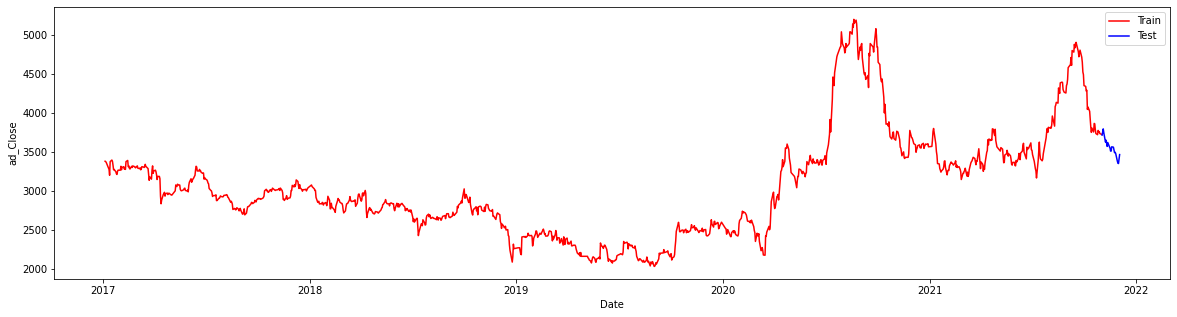

In [47]:
train_8194 = df_security_code(train_data, code=8194)
test_8194 = df_security_code(test_data, code=8194)

plt.figure(figsize=(20,5))


sns.lineplot(data=train_8194, y='ad_Close', x='Date', label="Train", color='red')
sns.lineplot(data=test_8194, y='ad_Close', x='Date', label="Test",color='blue')

Baseline 2.0

In [49]:
y_test_baseline = test_data[['Date', 'SecuritiesCode', 'ad_Target']]

In [50]:
def basline_prior_value(train_data, test_data):

    test_base = pd.DataFrame()

    for i in tqdm(test_data.SecuritiesCode.unique()):
        df_selected = test_data.query('SecuritiesCode == @i').sort_values('Date')
        df_selected_train = train_data.query('SecuritiesCode == @i').sort_values('Date')
        df_selected['base_pred'] = df_selected.ad_Target.shift(1)
        df_selected = df_selected.fillna(df_selected_train['ad_Target'].iloc[-1])

        test_base = pd.concat([test_base, df_selected])


    return test_base


In [51]:
test = basline_prior_value(train_data, test_data)

100%|██████████| 2000/2000 [00:21<00:00, 91.76it/s] 


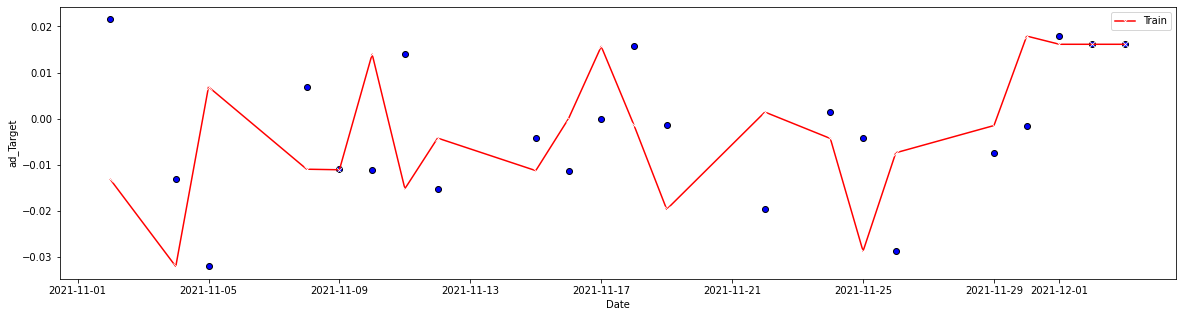

In [52]:
train_8194 = df_security_code(train_data, code=8194)
test_8194 = df_security_code(test, code=8194)

plt.figure(figsize=(20,5))


sns.lineplot(data=test_8194, y='ad_Target', x='Date', label="Train", color='red', marker='x')
plt.scatter(data=test_8194, y='base_pred', x='Date', label="Test",color='blue', marker='o', edgecolors='k')

In [53]:
def calculate_rank(data):
    new_df = pd.DataFrame()

    for i in data.Date.unique():
        df_current = data.query('Date == @i')
        df_current['Rank_ad_Target'] = df_current['ad_Target'].rank(ascending=False, method='first') -1
        df_current['Rank_baseline'] = df_current['base_pred'].rank(ascending=False, method='first') -1
        new_df = pd.concat([new_df, df_current])

    return new_df


In [54]:
test_rank = calculate_rank(test)

In [55]:
test_rank.sort_values('Rank_baseline').query('Rank_baseline >= 2000')

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth,base_pred,Rank_ad_Target,Rank_baseline


In [56]:
test_rank.query('Date == "2021-11-30"')['SecuritiesCode'].count()

2000

In [57]:
test_rank.query('Date == "2021-11-30" and SecuritiesCode == 6182')

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth,base_pred,Rank_ad_Target,Rank_baseline
1620890,20211130_6182,2021-11-30,6182,0.0,0,1119.0,1158.0,1107.0,1124.0,185500.0,...,12.426233,54000000.0,2.049000e+09,2.635432,10.204082,95.515267,-43.634028,0.024911,1986.0,148.0


In [58]:
test_rank.shape

(44000, 60)

In [59]:
for i in train_data.Date.unique():
    print(i, train_data.query('Date == @i')['SecuritiesCode'].nunique())

2017-01-04T00:00:00.000000000 1865
2017-01-05T00:00:00.000000000 1865
2017-01-06T00:00:00.000000000 1865
2017-01-10T00:00:00.000000000 1865
2017-01-11T00:00:00.000000000 1865
2017-01-12T00:00:00.000000000 1865
2017-01-13T00:00:00.000000000 1865
2017-01-16T00:00:00.000000000 1865
2017-01-17T00:00:00.000000000 1865
2017-01-18T00:00:00.000000000 1865
2017-01-19T00:00:00.000000000 1865
2017-01-20T00:00:00.000000000 1865
2017-01-23T00:00:00.000000000 1865
2017-01-24T00:00:00.000000000 1865
2017-01-25T00:00:00.000000000 1865
2017-01-26T00:00:00.000000000 1865
2017-01-27T00:00:00.000000000 1865
2017-01-30T00:00:00.000000000 1865
2017-01-31T00:00:00.000000000 1865
2017-02-01T00:00:00.000000000 1865
2017-02-02T00:00:00.000000000 1865
2017-02-03T00:00:00.000000000 1865
2017-02-06T00:00:00.000000000 1865
2017-02-07T00:00:00.000000000 1865
2017-02-08T00:00:00.000000000 1865
2017-02-09T00:00:00.000000000 1865
2017-02-10T00:00:00.000000000 1865
2017-02-13T00:00:00.000000000 1865
2017-02-14T00:00:00.

In [60]:
for i in test_data.Date.unique():
    print(i, test_data.query('Date == @i')['SecuritiesCode'].nunique())

2021-11-02T00:00:00.000000000 2000
2021-11-04T00:00:00.000000000 2000
2021-11-05T00:00:00.000000000 2000
2021-11-08T00:00:00.000000000 2000
2021-11-09T00:00:00.000000000 2000
2021-11-10T00:00:00.000000000 2000
2021-11-11T00:00:00.000000000 2000
2021-11-12T00:00:00.000000000 2000
2021-11-15T00:00:00.000000000 2000
2021-11-16T00:00:00.000000000 2000
2021-11-17T00:00:00.000000000 2000
2021-11-18T00:00:00.000000000 2000
2021-11-19T00:00:00.000000000 2000
2021-11-22T00:00:00.000000000 2000
2021-11-24T00:00:00.000000000 2000
2021-11-25T00:00:00.000000000 2000
2021-11-26T00:00:00.000000000 2000
2021-11-29T00:00:00.000000000 2000
2021-11-30T00:00:00.000000000 2000
2021-12-01T00:00:00.000000000 2000
2021-12-02T00:00:00.000000000 2000
2021-12-03T00:00:00.000000000 2000


In [74]:
prices = df.query('Date == "2021-11-01" and SecuritiesCode == 7616')

In [75]:
prices

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
2113641,20211101_7616,2021-11-01,7616,0.0,0,1666.0,1672.0,1651.0,1670.0,259500.0,...,11.0,2021.0,44.0,1.527375,719000000.0,3.933000e+10,1.828121,-107.391036,-76.614481,-131.605183


In [62]:
df.query('SecuritiesCode == 6182 and Date == "2021-11-30"')

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
1620890,20211130_6182,2021-11-30,6182,0.0,0,1119.0,1158.0,1107.0,1124.0,185500.0,...,11.0,2021.0,48.0,12.426233,54000000.0,2.049000e+09,2.635432,10.204082,95.515267,-43.634028


In [63]:
df.query('SecuritiesCode == 6182 and Date > "2021-11-01"').Date.value_counts()

2021-11-02    1
2021-11-04    1
2021-12-02    1
2021-12-01    1
2021-11-30    1
2021-11-29    1
2021-11-26    1
2021-11-25    1
2021-11-24    1
2021-11-22    1
2021-11-19    1
2021-11-18    1
2021-11-17    1
2021-11-16    1
2021-11-15    1
2021-11-12    1
2021-11-11    1
2021-11-10    1
2021-11-09    1
2021-11-08    1
2021-11-05    1
2021-12-03    1
Name: Date, dtype: int64

In [64]:
df = df.drop_duplicates()

In [65]:
a = test_data.query('Date == "2021-11-02"')['SecuritiesCode']
b = test_data.query('Date == "2021-11-05"')['SecuritiesCode']

In [66]:
list(set(b) - set(a))

[]

In [67]:
df.query('Date == "2021-11-02" and SecuritiesCode == 7616')

,RowId,Date,SecuritiesCode,ExpectedDividend,SupervisionFlag,ad_Open,ad_High,ad_Low,ad_Close,ad_Volume,...,Month,Year,week,Volatility_week,Profit,NetSales,margin,win_quarter_growth,rev_quarter_growth,margin_growth
2113642,20211102_7616,2021-11-02,7616,0.0,0,1675.0,1685.0,1665.0,1673.0,334900.0,...,11.0,2021.0,44.0,1.527375,719000000.0,3.933000e+10,1.828121,-107.391036,-76.614481,-131.605183


In [68]:
test_data.query('Date == "2021-11-02" and SecuritiesCode == 7616')['SecuritiesCode']

2113642    7616
Name: SecuritiesCode, dtype: int64

In [69]:
test_data.query('Date == "2021-11-05 and SecuritiesCode == 7616"')['SecuritiesCode']

Series([], Name: SecuritiesCode, dtype: int64)

In [70]:
missingValues(test_data)

,N_missing,Percentage
RowId,0.0,0.0
detrend_ad_High,0.0,0.0
error_ad_High,0.0,0.0
ad_Low_lag1,0.0,0.0
ad_Low_sma10,0.0,0.0
logprice_ad_Low,0.0,0.0
trend_ad_Low,0.0,0.0
detrend_ad_Low,0.0,0.0
season_ad_Low,0.0,0.0
error_ad_Low,0.0,0.0


In [76]:
features = ['ad_Close', 'trend_ad_Close','detrend_ad_Close','season_ad_Close' ,'error_ad_Close']

In [77]:
train_data[features].describe()

,ad_Close,trend_ad_Close,detrend_ad_Close,season_ad_Close,error_ad_Close
count,2.288275e+06,2.230275e+06,2.230275e+06,2.230275e+06,2230275.0
mean,2.839158e+03,2.836542e+03,1.755515e+01,1.755515e+01,0.0
std,5.378939e+03,5.341793e+03,4.512809e+02,4.512809e+02,0.0
min,1.030000e+01,1.203333e+01,-2.731200e+04,-2.731200e+04,0.0
25%,8.480000e+02,8.506333e+02,-4.500000e+01,-4.500000e+01,0.0
50%,1.684000e+03,1.686333e+03,2.500000e+00,2.500000e+00,0.0
75%,3.142000e+03,3.145600e+03,5.916667e+01,5.916667e+01,0.0
max,3.039200e+05,2.756947e+05,3.860400e+04,3.860400e+04,0.0


<AxesSubplot:xlabel='Date', ylabel='season_ad_Close'>

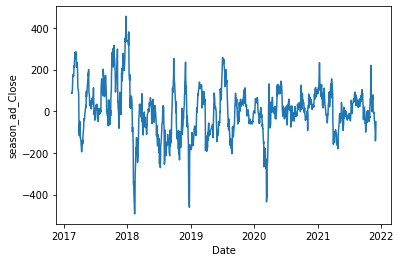

In [79]:
a = df.query('SecuritiesCode == 1301')
sns.lineplot(data=a, x='Date', y= 'season_ad_Close')